In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
from itertools import combinations, cycle, islice
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration
from sklearn.feature_extraction import DictVectorizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [2]:
from metagov import cryptopolitics
from metagov.cryptopolitics import SAVEDIR, QUESTIONS, COLS_QUESTIONS, COLS_RESULTS, FACTION_ORDERS, n2q

In [3]:
SAVEFIG = False
fig_ext = '.png'
fig_kwargs = cryptopolitics.KWARGS_PNG

politics: ['Crypto-leftist', 'DAOist', 'True neutral', 'Crypto-libertarian', 'Crypto-ancap']
economics: ['Earner', 'Cryptopunk', 'NPC', 'Techtrepreneur', 'Degen']
governance: ['Walchian', 'Zamfirist', 'Noob', 'Gavinist', 'Szabian']


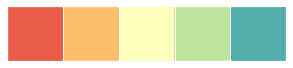

In [4]:
# In case a lot of clusters are found
COLORS = np.array(sns.color_palette('bright').as_hex() + \
                  sns.color_palette('pastel').as_hex() + \
                  sns.color_palette('dark').as_hex() + \
                  sns.color_palette('muted').as_hex())
FIVE_COLORS = sns.color_palette("Spectral", 5)
COLORS_MIN = np.array(FIVE_COLORS.as_hex())
sns.palplot(FIVE_COLORS)
for k, v in FACTION_ORDERS.items():
    print(f"{k}: {v}")

# Cryptopolitical Typology Quiz analysis - dimensionality reduction and factor analysis

The [Cryptopolitical Typology Quiz](https://metagov.typeform.com/cryptopolitics) was developed by the [Metagovernance Project](https://metagov.org/) to help the crypto community understand its political, economic, and governance beliefs. Survey results were collected from September 27, 2021 through March 4, 2022 and have been published on the [Govbase Airtable database](https://airtable.com/shr9LYMni8pBUVD6q/tblvwbt4KFm8MOSUQ). 

In [5]:
data = cryptopolitics.load_data()
df_questions, df_results = data.values()

## Method
We built the initial set of factions by hand, but we were curious whether these or factions and features might arise naturally from the data. To look for these, we used feature selection methods (e.g. PCA, feature agglomeration). The hope was to identify and describe groupings of questions in a meaningful way. We might hope to find axes that correspond to something like the "politics" or "economics" axes defined in the survey, or some other belief/value axis not yet identified. These would allow us to view the data as projected onto these axes.
    
- **PCA (principal component analysis)** (mixed encoding only)
- **Feature agglomeration**

An alternative method that could be relevant here is multiple correspondence analysis.

Steps involved:
- **Preprocessing** (how to encode the data)
- **Feature selection** (to find which questions most explain variance between respondents) and **dimensionality reduction** (to visualize the clusters; could also be a preprocessing step), i.e., grouping the questions by the responses

General process notes:
- For many clustering methods, the **distance** or **affinity** metric chosen greatly affects the resulting fit. Since ultimately this data is categorical, wherever there was the option, "manhattan" (cityblock) distance was chosen.

## Preprocessing
- Drop questions relating to specific ecosystems (Q2, Q19)
- Drop rows with any unanswered questions
- **Encode the data** in two ways:
    - **Categorical**: All questions one-hot encoded (49 columns)
    - **Mixed**: All but four categorical questions mapped to ordinal values on -1 to 1 scale, with the remaining questions one-hot encoded (29 columns). The one-hot encoded values are rescaled to reduce their weight relative to the ordinal encoded questions, since each question was split up into four features. *Warning*: this ordinal mapping, done subjectively, greatly affects subsequent results! See the .csv file for the mapping definition.

In [6]:
# Preprocessing
df_tmp = df_questions.copy().drop(columns=['Q2', 'Q19'])
df_to_cluster = df_tmp.dropna()
df_result_to_cluster = df_results.loc[df_to_cluster.index, :]
COLS_QUESTIONS_clustering = COLS_QUESTIONS.copy()
COLS_QUESTIONS_clustering.remove('Q2')
COLS_QUESTIONS_clustering.remove('Q19')

In [7]:
def get_color(faction):
    return list(df_result_to_cluster[faction].apply(lambda x: COLORS_MIN[FACTION_ORDERS[faction].index(x)]))

colors_pol = get_color('politics')
colors_econ = get_color('economics')
colors_gov = get_color('governance')

#### Categorical encoding (one-hot)

In [8]:
# Encode all questions as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
df_allCat = pd.DataFrame(X_allCat, columns=v.get_feature_names_out())

df_allCat.shape

(3418, 48)

## PCA
Besides providing a set of axes on which to project the data for visualization, the first few PCA components could help us understand which questions are most important in explaining variance between respondents. An important caveat: since PCA assumes numerical data, the component values do not correspond exactly to possible encoded answer values. By snapping these values to the nearest possible answer, we can get an approximation of this.

In [9]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    color = cryptopolitics.DEFAULT_COLOR
    if colors is not None:
        color = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], color=color, alpha=0.25)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

In [10]:
def compute_pca(X, N, labels=None):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)

    print(f"Total variance explained by {N} components: {100*sum(pca.explained_variance_ratio_):.1f}%")    
    
    # Display PCA vectors against one another
    df_tmp = pd.DataFrame(np.transpose(pca.components_))
    if labels is not None:
        df_tmp.index = labels
    if len(df_tmp.columns) > 3:
        df_tmp = df_tmp.iloc[:, :3]
    df_tmp.plot.bar(width=0.75, figsize=(12,6))
    plt.ylabel('Component value')
    
    # Find most relevant choices
    threshold = 0.15
    print(f"With threshold of magnitude >= {threshold}:")
    for comp in [0,1,2]:
        #choices = []
        features = pca.components_[comp,:]
        features_enum = [(i,f) for i,f in enumerate(features)]
        features_sorted = sorted(features_enum, reverse=True, key=(lambda x: abs(x[1])))
        cumsum = 0
        print(f"\nComponent {comp}")
        print("Mag.\tCum.\tFeature")
        for i in range(len(features)):
            feature = features_sorted[i]
            if abs(feature[1]) < threshold:
                break
            cumsum = np.sqrt(feature[1]**2 + cumsum**2)
            print(f"{feature[1]:.2f}\t{cumsum:.2f}\t{labels[feature[0]]}")
    
    if SAVEFIG:
        # Save original and closest-possible-response versions of results for interpretation
        df_tmp.to_csv(f"{SAVEDIR}/cryptopolitics_pca.csv")
    
    # Scree plot
    plt.figure()
    plt.plot(np.arange(pca.n_components_) + 1, 100*pca.explained_variance_ratio_,
                'o-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.show()

    return X_transformed, pca

### PCA on categorical data
Display only first three components for convenience.

In [11]:
n_PCA = 17 # Number of questions included in this analysis

Total variance explained by 17 components: 79.7%
With threshold of magnitude >= 0.15:

Component 0
Mag.	Cum.	Feature
-0.35	0.35	Q12=The economic system in crypto is generally fair to most of its participants.
0.35	0.50	Q12=The economic system in crypto unfairly favors powerful interests.
-0.27	0.57	Q15=Crypto does not have a gender problem.
0.27	0.63	Q15=Crypto has a gender problem.
0.25	0.68	Q18=Liberal or left-wing
-0.25	0.72	Q11=Most crypto teams make a fair and reasonable amount of profit.
0.25	0.76	Q11=Crypto teams make too much profit.
-0.24	0.80	Q7=Government regulation of crypto will almost always do more harm than good.
0.20	0.83	Q13=In crypto, hard work and determination are no guarantee of success for most people.
-0.20	0.85	Q13=Most people who want to get ahead in crypto can make it if they're willing to work hard.
-0.17	0.87	Q18=Neither
0.16	0.88	Q16=A wide variety of on- and off-chain stakeholders including token holders, node operators, application developers, foundation

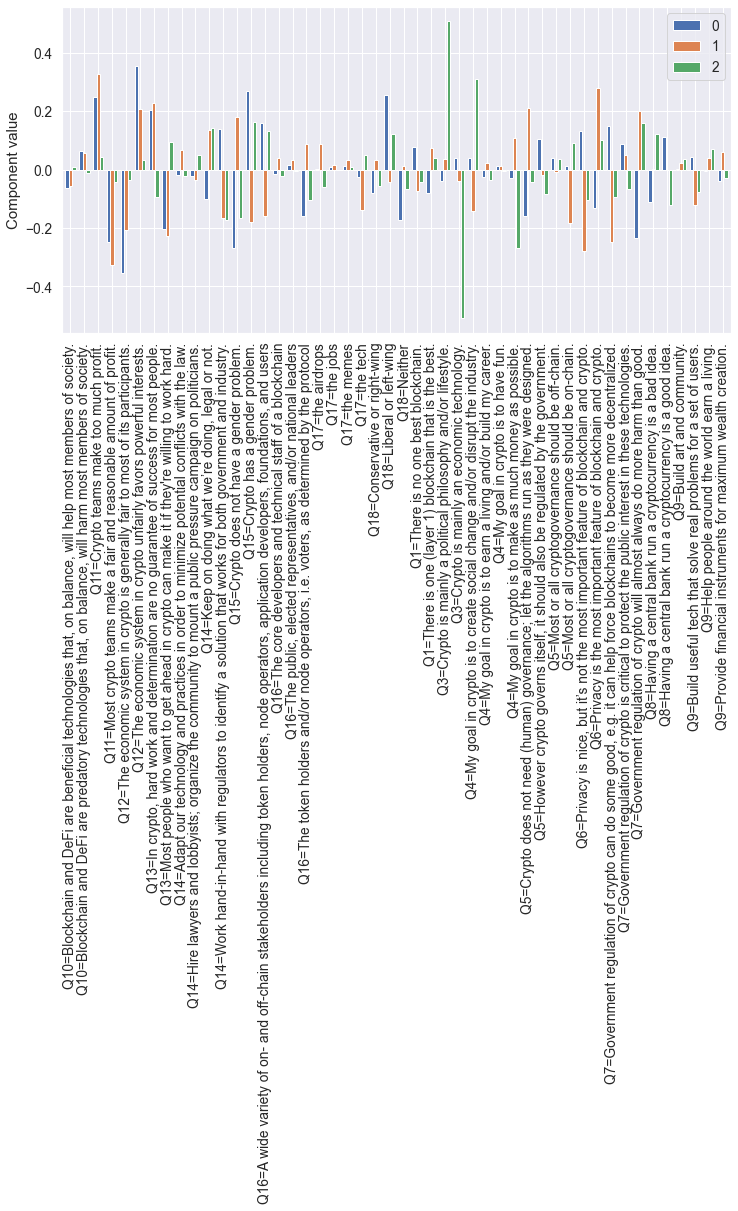

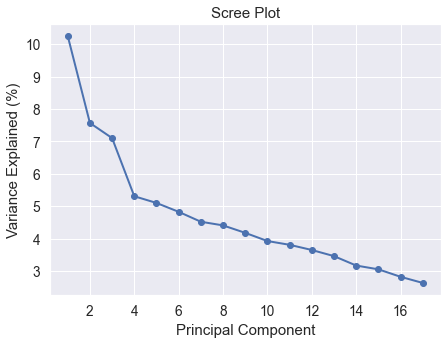

In [12]:
# Plot with political faction colors
X_pca, pca_result = compute_pca(X_allCat, n_PCA, 
                                labels=list(df_allCat.columns))

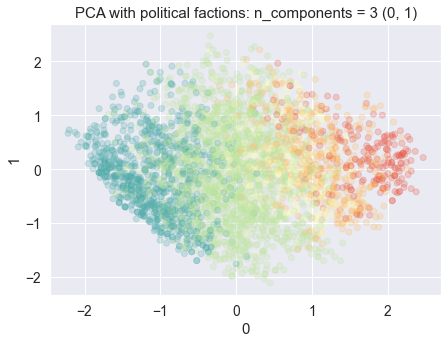

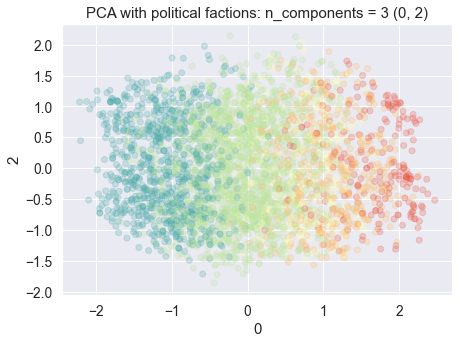

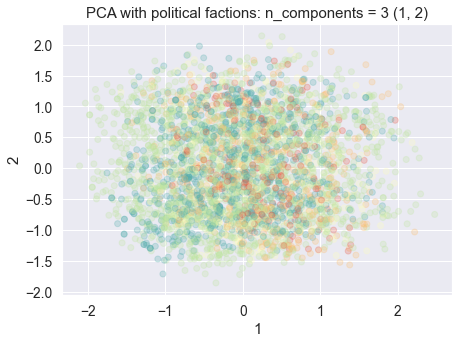

In [13]:
# Plot with political faction colors
scatter_plot_combos(X_pca, 3, title='PCA with political factions', colors=colors_pol)

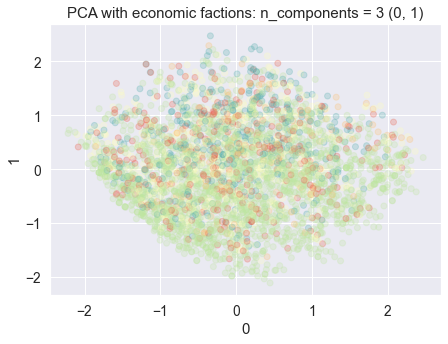

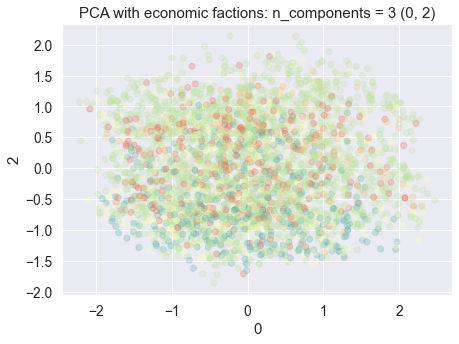

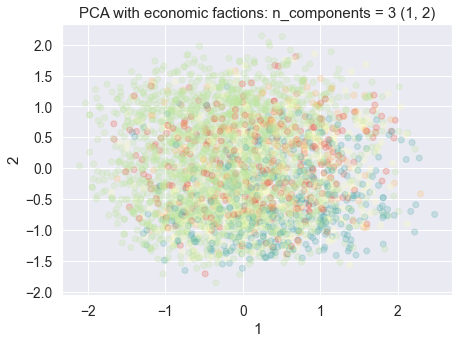

In [14]:
# Plot with economic faction colors
scatter_plot_combos(X_pca, 3, title='PCA with economic factions', colors=colors_econ)

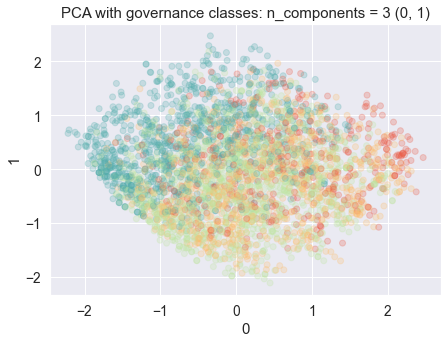

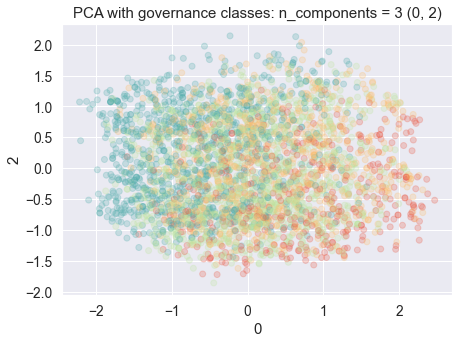

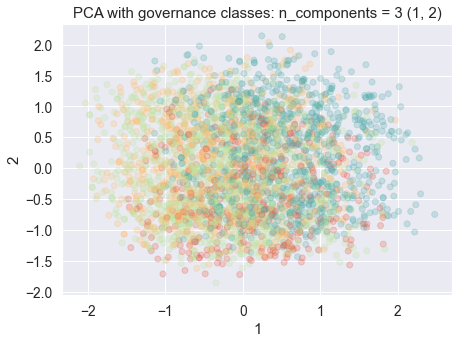

In [15]:
# Plot with governance class colors
scatter_plot_combos(X_pca, 3, title='PCA with governance classes', colors=colors_gov)

Based on the PCA component values, Q3, Q5, Q14 (government regulation), Q15 (gender) may play the greatest role in differentiating respondents. However, the variance explained by the first 2-3 components is fairly low (less than 50%), so these results are pretty weak.

Even so, we'll use these components to visualize the clustering later.

#### Feature agglomeration

In [16]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Copied from scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [17]:
def compute_feature_agglomeration(X, N, labels=None, kwargs={}):
    """Compute and plot feature agglomeration transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    fa = FeatureAgglomeration(n_clusters=N, compute_distances=True, **kwargs) #cosine, cityblock, hamming, dice
    X_transformed = fa.fit_transform(X)

    # Display some results
    if labels is not None:
        features = pd.DataFrame([{'question': labels[i], 'feature': x} for (i, x) in enumerate(fa.labels_)])
        gb = features.groupby(by='feature')
        for key, item in gb:
            print(f"feature {key}")
            print(gb.get_group(key)['question'].values, "\n")

    # Plot dendrogram of connections between clusters
    plt.figure()
    plot_dendrogram(fa, truncate_mode="lastp", p=N)
    
    return X_transformed, fa

In [18]:
kwargs_fa_allCat = {'affinity': 'manhattan', 'linkage': 'complete'}
nFeatures = 3
nQuestions = 17

feature 0
['Q10=Blockchain and DeFi are beneficial technologies that, on balance, will help most members of society.'
 'Q1=There is no one best blockchain.'
 'Q6=Privacy is nice, but it’s not the most important feature of blockchain and crypto.'
 'Q8=Having a central bank run a cryptocurrency is a bad idea.'
 'Q9=Build useful tech that solve real problems for a set of users.'] 

feature 1
['Q16=The token holders and/or node operators, i.e. voters, as determined by the protocol'
 'Q4=My goal in crypto is to make as much money as possible.'] 

feature 2
['Q14=Work hand-in-hand with regulators to identify a solution that works for both government and industry.'
 'Q7=Government regulation of crypto can do some good, e.g. it can help force blockchains to become more decentralized.'] 

feature 3
['Q3=Crypto is mainly a political philosophy and/or lifestyle.'
 'Q4=My goal in crypto is to create social change and/or disrupt the industry.'] 

feature 4
['Q10=Blockchain and DeFi are predatory te

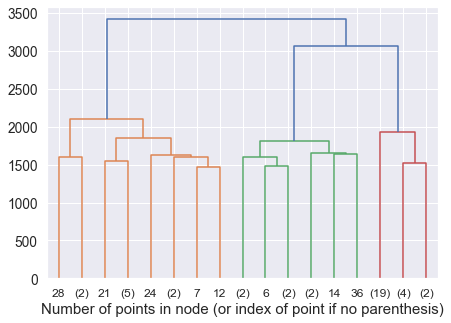

In [19]:
# Feature agglomeration on categorical data - 17 features
X_fa_allCat, fa_result_allCat = compute_feature_agglomeration(X_allCat, nQuestions,
                                                              labels=df_allCat.columns,
                                                              kwargs=kwargs_fa_allCat)

feature 0
['Q10=Blockchain and DeFi are beneficial technologies that, on balance, will help most members of society.'
 'Q11=Most crypto teams make a fair and reasonable amount of profit.'
 'Q12=The economic system in crypto is generally fair to most of its participants.'
 "Q13=Most people who want to get ahead in crypto can make it if they're willing to work hard."
 'Q14=Work hand-in-hand with regulators to identify a solution that works for both government and industry.'
 'Q15=Crypto does not have a gender problem.' 'Q17=the tech' 'Q18=Neither'
 'Q1=There is no one best blockchain.'
 'Q3=Crypto is mainly an economic technology.'
 'Q6=Privacy is nice, but it’s not the most important feature of blockchain and crypto.'
 'Q7=Government regulation of crypto can do some good, e.g. it can help force blockchains to become more decentralized.'
 'Q8=Having a central bank run a cryptocurrency is a bad idea.'
 'Q9=Build useful tech that solve real problems for a set of users.'] 

feature 1
['Q10=

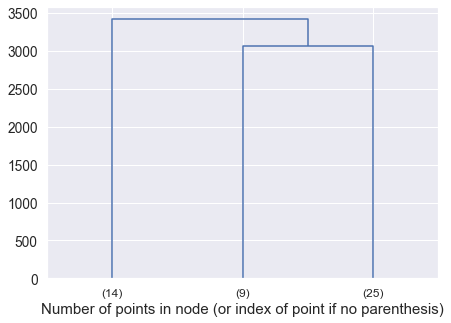

In [20]:
# Feature agglomeration on categorical data - 4 features
X_fa_allCat, fa_result_allCat = compute_feature_agglomeration(X_allCat, nFeatures,
                                                              labels=df_allCat.columns,
                                                              kwargs=kwargs_fa_allCat)

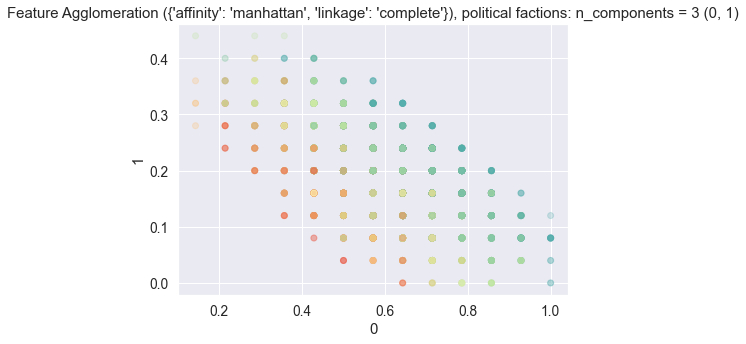

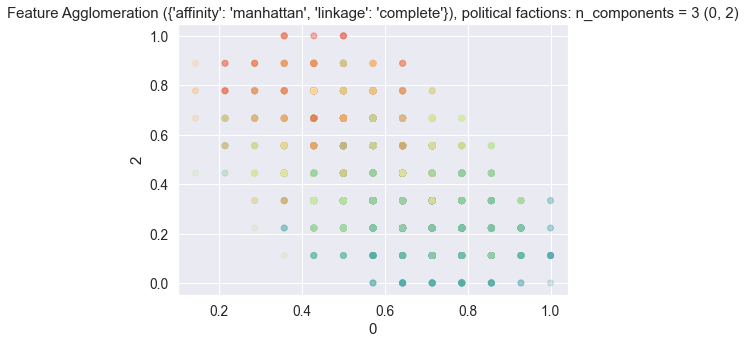

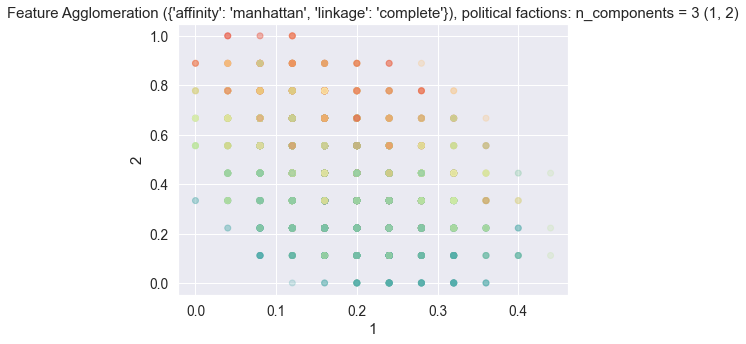

In [21]:
# Plot with political faction colors
scatter_plot_combos(X_fa_allCat,
                    nFeatures,
                    title=f"Feature Agglomeration ({kwargs_fa_allCat}), political factions",
                    colors=colors_pol)

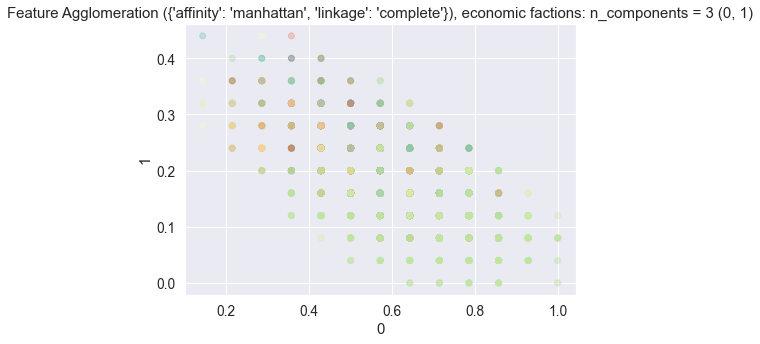

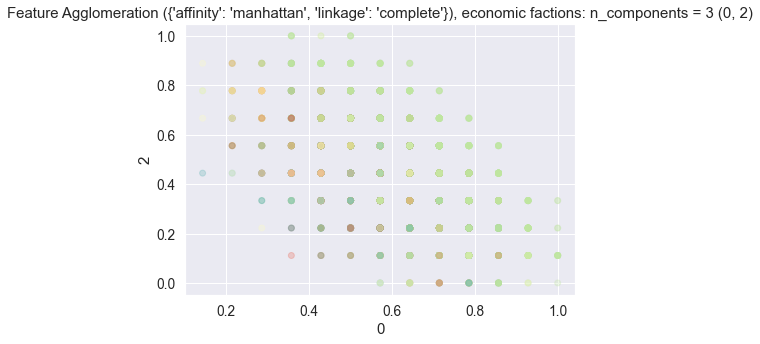

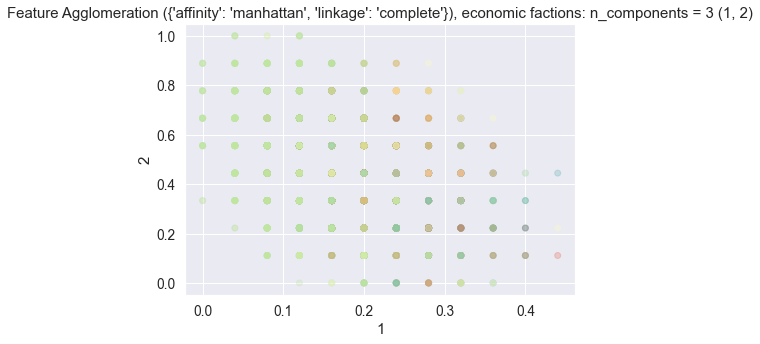

In [22]:
# Plot with economic faction colors
scatter_plot_combos(X_fa_allCat,
                    nFeatures,
                    title=f"Feature Agglomeration ({kwargs_fa_allCat}), economic factions",
                    colors=colors_econ)

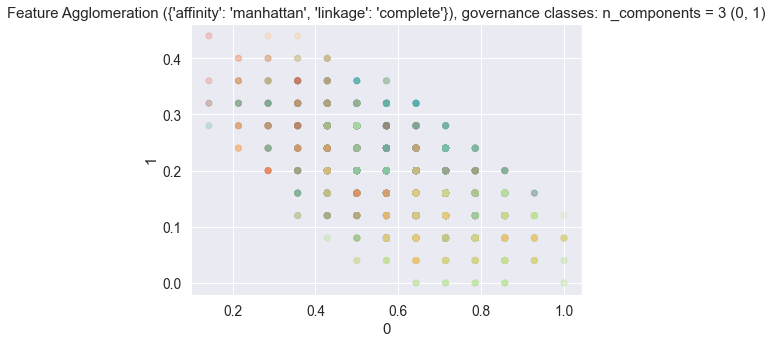

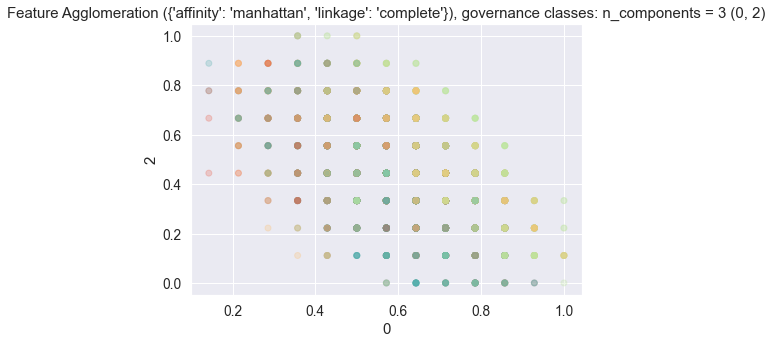

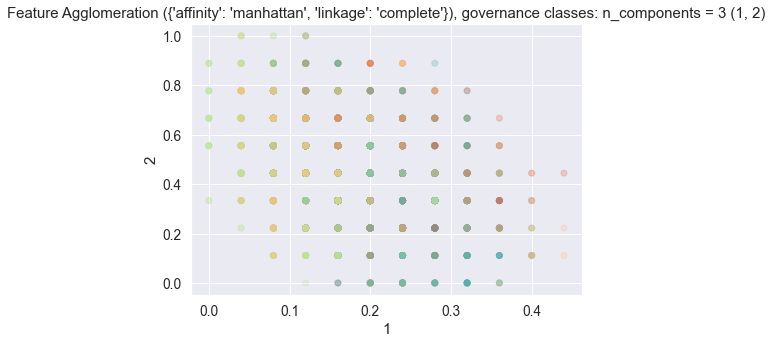

In [23]:
# Plot with governance class colors
scatter_plot_combos(X_fa_allCat,
                    nFeatures,
                    title=f"Feature Agglomeration ({kwargs_fa_allCat}), governance classes",
                    colors=colors_gov)